In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS


In [2]:
tickers = ['AAPL', 'MSFT']  # Example tickers
start_date = '2020-01-01'
end_date = '2024-01-01'

data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']


[*********************100%***********************]  2 of 2 completed


In [3]:
score, p_value, _ = coint(data['AAPL'], data['MSFT'])
print(f'Cointegration test p-value: {p_value}')


Cointegration test p-value: 0.2206170346365341


In [4]:
spread = data['AAPL'] - data['MSFT']
print(spread.head())


Date
2020-01-02 00:00:00+00:00   -81.062088
2020-01-03 00:00:00+00:00   -79.853783
2020-01-06 00:00:00+00:00   -79.671692
2020-01-07 00:00:00+00:00   -78.624115
2020-01-08 00:00:00+00:00   -79.865028
dtype: float64


In [5]:
window = 30
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()
print(rolling_mean.head(), rolling_std.head())


Date
2020-01-02 00:00:00+00:00   NaN
2020-01-03 00:00:00+00:00   NaN
2020-01-06 00:00:00+00:00   NaN
2020-01-07 00:00:00+00:00   NaN
2020-01-08 00:00:00+00:00   NaN
dtype: float64 Date
2020-01-02 00:00:00+00:00   NaN
2020-01-03 00:00:00+00:00   NaN
2020-01-06 00:00:00+00:00   NaN
2020-01-07 00:00:00+00:00   NaN
2020-01-08 00:00:00+00:00   NaN
dtype: float64


In [6]:
spread_zscore = (spread - rolling_mean) / rolling_std
print(spread_zscore.head())


Date
2020-01-02 00:00:00+00:00   NaN
2020-01-03 00:00:00+00:00   NaN
2020-01-06 00:00:00+00:00   NaN
2020-01-07 00:00:00+00:00   NaN
2020-01-08 00:00:00+00:00   NaN
dtype: float64


In [7]:
entry_threshold = 2
exit_threshold = 0

data['zscore'] = spread_zscore
data['longs'] = (data['zscore'] < -entry_threshold).astype(int)
data['shorts'] = (data['zscore'] > entry_threshold).astype(int)
data['exits'] = (abs(data['zscore']) < exit_threshold).astype(int)

print(data[['zscore', 'longs', 'shorts', 'exits']].head())


Ticker                     zscore  longs  shorts  exits
Date                                                   
2020-01-02 00:00:00+00:00     NaN      0       0      0
2020-01-03 00:00:00+00:00     NaN      0       0      0
2020-01-06 00:00:00+00:00     NaN      0       0      0
2020-01-07 00:00:00+00:00     NaN      0       0      0
2020-01-08 00:00:00+00:00     NaN      0       0      0


In [8]:
initial_cash = 100000
data['positions'] = 0
data.loc[data['longs'] == 1, 'positions'] = 1
data.loc[data['shorts'] == 1, 'positions'] = -1
data.loc[data['exits'] == 1, 'positions'] = 0
data['positions'] = data['positions'].ffill()

data['returns'] = data['positions'].shift(1) * (data['AAPL'].pct_change() - data['MSFT'].pct_change())
data['cumulative_returns'] = (1 + data['returns']).cumprod() - 1
data['portfolio_value'] = initial_cash * (1 + data['cumulative_returns'])

print(data[['positions', 'returns', 'cumulative_returns', 'portfolio_value']].head())


Ticker                     positions  returns  cumulative_returns  \
Date                                                                
2020-01-02 00:00:00+00:00          0      NaN                 NaN   
2020-01-03 00:00:00+00:00          0      0.0                 0.0   
2020-01-06 00:00:00+00:00          0      0.0                 0.0   
2020-01-07 00:00:00+00:00          0      0.0                 0.0   
2020-01-08 00:00:00+00:00          0      0.0                 0.0   

Ticker                     portfolio_value  
Date                                        
2020-01-02 00:00:00+00:00              NaN  
2020-01-03 00:00:00+00:00         100000.0  
2020-01-06 00:00:00+00:00         100000.0  
2020-01-07 00:00:00+00:00         100000.0  
2020-01-08 00:00:00+00:00         100000.0  


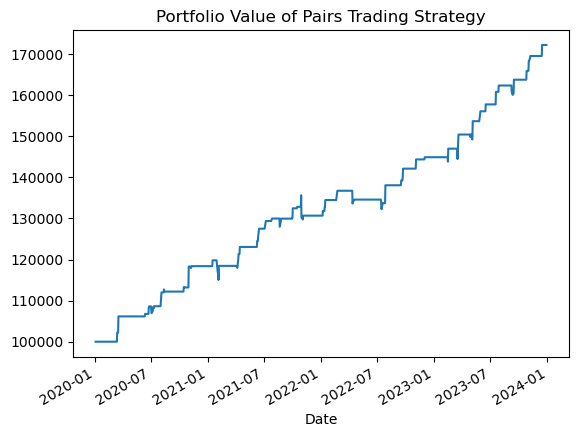

In [9]:
data['portfolio_value'].plot()
plt.title('Portfolio Value of Pairs Trading Strategy')
plt.show()


In [10]:
from itertools import product

entry_thresholds = np.arange(1.5, 3.5, 0.5)
exit_thresholds = np.arange(0.5, 1.5, 0.5)
best_sharpe = -np.inf
best_params = None

for entry, exit in product(entry_thresholds, exit_thresholds):
    data['longs'] = (data['zscore'] < -entry).astype(int)
    data['shorts'] = (data['zscore'] > entry).astype(int)
    data['exits'] = (abs(data['zscore']) < exit).astype(int)

    data['positions'] = 0
    data.loc[data['longs'] == 1, 'positions'] = 1
    data.loc[data['shorts'] == 1, 'positions'] = -1
    data.loc[data['exits'] == 1, 'positions'] = 0
    data['positions'] = data['positions'].ffill()

    data['returns'] = data['positions'].shift(1) * (data['AAPL'].pct_change() - data['MSFT'].pct_change())
    sharpe_ratio = data['returns'].mean() / data['returns'].std() * np.sqrt(252)

    if sharpe_ratio > best_sharpe:
        best_sharpe = sharpe_ratio
        best_params = (entry, exit)

print(f'Best Entry Threshold: {best_params[0]}, Best Exit Threshold: {best_params[1]}')


Best Entry Threshold: 2.0, Best Exit Threshold: 0.5


In [11]:
transaction_cost = 0.001  # 0.1% per trade

data['trade'] = data['positions'].diff().abs()
data['returns'] = data['positions'].shift(1) * (data['AAPL'].pct_change() - data['MSFT'].pct_change()) - data['trade'] * transaction_cost
data['cumulative_returns'] = (1 + data['returns']).cumprod() - 1
data['portfolio_value'] = initial_cash * (1 + data['cumulative_returns'])

print(data[['positions', 'returns', 'cumulative_returns', 'portfolio_value']].head())


Ticker                     positions  returns  cumulative_returns  \
Date                                                                
2020-01-02 00:00:00+00:00          0      NaN                 NaN   
2020-01-03 00:00:00+00:00          0      0.0                 0.0   
2020-01-06 00:00:00+00:00          0      0.0                 0.0   
2020-01-07 00:00:00+00:00          0      0.0                 0.0   
2020-01-08 00:00:00+00:00          0      0.0                 0.0   

Ticker                     portfolio_value  
Date                                        
2020-01-02 00:00:00+00:00              NaN  
2020-01-03 00:00:00+00:00         100000.0  
2020-01-06 00:00:00+00:00         100000.0  
2020-01-07 00:00:00+00:00         100000.0  
2020-01-08 00:00:00+00:00         100000.0  


In [12]:
stop_loss = -0.05  # 5% loss
take_profit = 0.05  # 5% gain

data['stop_loss'] = (data['returns'] < stop_loss).astype(int)
data['take_profit'] = (data['returns'] > take_profit).astype(int)
data['positions'] = 0
data.loc[data['longs'] == 1, 'positions'] = 1
data.loc[data['shorts'] == 1, 'positions'] = -1
data.loc[data['exits'] == 1, 'positions'] = 0
data.loc[data['stop_loss'] == 1, 'positions'] = 0
data.loc[data['take_profit'] == 1, 'positions'] = 0
data['positions'] = data['positions'].ffill()

data['returns'] = data['positions'].shift(1) * (data['AAPL'].pct_change() - data['MSFT'].pct_change())
data['cumulative_returns'] = (1 + data['returns']).cumprod() - 1
data['portfolio_value'] = initial_cash * (1 + data['cumulative_returns'])

print(data[['positions', 'returns', 'cumulative_returns', 'portfolio_value']].head())


Ticker                     positions  returns  cumulative_returns  \
Date                                                                
2020-01-02 00:00:00+00:00          0      NaN                 NaN   
2020-01-03 00:00:00+00:00          0      0.0                 0.0   
2020-01-06 00:00:00+00:00          0      0.0                 0.0   
2020-01-07 00:00:00+00:00          0      0.0                 0.0   
2020-01-08 00:00:00+00:00          0      0.0                 0.0   

Ticker                     portfolio_value  
Date                                        
2020-01-02 00:00:00+00:00              NaN  
2020-01-03 00:00:00+00:00         100000.0  
2020-01-06 00:00:00+00:00         100000.0  
2020-01-07 00:00:00+00:00         100000.0  
2020-01-08 00:00:00+00:00         100000.0  


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

data['spread'] = spread
data['spread_lagged'] = data['spread'].shift(1)
data.dropna(inplace=True)

X = data[['spread_lagged']]
y = data['spread']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

data['spread_pred'] = model.predict(X)
data['zscore_pred'] = (data['spread_pred'] - rolling_mean) / rolling_std

data['longs'] = (data['zscore_pred'] < -entry_threshold).astype(int)
data['shorts'] = (data['zscore_pred'] > entry_threshold).astype(int)
data['exits'] = (abs(data['zscore_pred']) < exit_threshold).astype(int)

data['positions'] = 0
data.loc[data['longs'] == 1, 'positions'] = 1
data.loc[data['shorts'] == 1, 'positions'] = -1
data.loc[data['exits'] == 1, 'positions'] = 0
data['positions'] = data['positions'].ffill()

data['returns'] = data['positions'].shift(1) * (data['AAPL'].pct_change() - data['MSFT'].pct_change())
data['cumulative_returns'] = (1 + data['returns']).cumprod() - 1
data['portfolio_value'] = initial_cash * (1 + data['cumulative_returns'])

print(data[['positions', 'returns', 'cumulative_returns', 'portfolio_value']].head())


Ticker                     positions  returns  cumulative_returns  \
Date                                                                
2020-02-13 00:00:00+00:00          0      NaN                 NaN   
2020-02-14 00:00:00+00:00          0     -0.0                 0.0   
2020-02-18 00:00:00+00:00          0     -0.0                 0.0   
2020-02-19 00:00:00+00:00          0      0.0                 0.0   
2020-02-20 00:00:00+00:00          0      0.0                 0.0   

Ticker                     portfolio_value  
Date                                        
2020-02-13 00:00:00+00:00              NaN  
2020-02-14 00:00:00+00:00         100000.0  
2020-02-18 00:00:00+00:00         100000.0  
2020-02-19 00:00:00+00:00         100000.0  
2020-02-20 00:00:00+00:00         100000.0  


In [14]:
annual_return = data['returns'].mean() * 252
annual_volatility = data['returns'].std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_volatility

print(f'Annual Return: {annual_return:.2%}')
print(f'Annual Volatility: {annual_volatility:.2%}')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')


Annual Return: 0.04%
Annual Volatility: 5.37%
Sharpe Ratio: 0.01


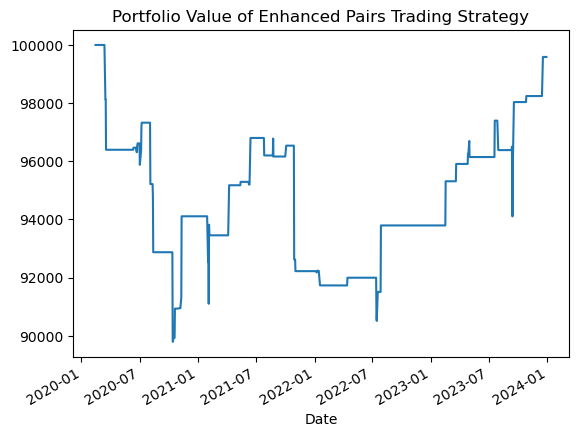

In [15]:
data['portfolio_value'].plot()
plt.title('Portfolio Value of Enhanced Pairs Trading Strategy')
plt.show()
